<a href="https://colab.research.google.com/github/Joyatulya/colab_notebooks/blob/main/CXR_Semi_Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Sep 12 15:47:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !sudo apt install -qq cadaver
# username BIMCV-PadChest-FULL
# !cadaver https://b2drop.bsc.es/public.php/webdav/

#Pretraining Prep

##Setting up Enviornment

In [ ]:
!git clone -q  https://github.com/Joyatulya/utils.git
!pip -qq install transformers pytorch-lightning wandb torchtyping timm
# !pip -qq install captum
!pip -qq install pytorch-ignite
# !pip -qq install -U rich
# !pip -qq install grad-cam
# !pip install vissl

fatal: destination path 'utils' already exists and is not an empty directory.
     |████████████████████████████████| 509 kB 14.0 MB/s 


In [ ]:
from utils import enviornmet_setup
enviornmet_setup.config_files()

Copying Kaggle/wandb/git


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar, LearningRateMonitor
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
from torch import optim
import torchvision.transforms as T
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import wandb  
from glob import glob
from torchvision import io
import h5py
import shutil
import pathlib
from pytorch_lightning.loggers import WandbLogger
import cv2
from tqdm.auto import tqdm
from torchvision.io.image import ImageReadMode
import copy
from sklearn.model_selection import train_test_split

In [ ]:
wandb.login()
pl.seed_everything(1996)

wandb: Currently logged in as: joy_atulya. Use `wandb login --relogin` to force relogin
INFO:pytorch_lightning.utilities.seed:Global seed set to 1996


1996

In [ ]:
CLINICAL_LABELS = ['PatientID', "PatientBirth",'PatientSex_DICOM', 'ViewPosition_DICOM','Pediatric','ReportID','Report','MethodLabel','Labels','Localizations','LabelsLocalizationsBySentence','labelCUIS', 'LocalizationsCUIS']
HOME_DIR = pathlib.Path().cwd() / 'drive' / 'MyDrive' / 'adv_cxr'

##Data Preparation

In [ ]:
pad_df = pd.read_csv( HOME_DIR / 'padchest' / 'padchest.csv')
nih_df = pd.read_csv( HOME_DIR / 'nih' / 'nih.csv')
vinbig_df = pd.read_csv( HOME_DIR / 'vinbig' / 'vinbig.csv')
tb_df = pd.read_csv( HOME_DIR / 'tb' / 'tb.csv')
combined_df = pd.read_csv(HOME_DIR / 'combined_dataset.csv')
assert len(pad_df) + len(nih_df) + len(vinbig_df) + len(tb_df) == len(combined_df), 'Length of all dataframes dont add up'
# combined_df.rename({'max' : 'max_value'}, axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### BIMCV df

In [ ]:
# items_in_h5 = []
# # for key, val in padchest_ds.imgs.items():
#   # items_in_h5.append((key, len(val)))
# for i in range(51):
#   print(padchest_ds.img_names[str(i)], padchest_ds.imgs[str(i)])
# padchest_ds.img_names, padchest_ds.imgs

In [ ]:
# for file_num in range(51):
#   if not pad_df[pad_df.file == file_num].shape == pad_df[pad_df.ImageDir == file_num].shape:
#     print(pad_df[pad_df.ImageDir == file_num].shape)
#     print(pad_df[pad_df.file == file_num].shape)
#     print(file_num)



In [ ]:
# items_in_text_file = []
# for num , f in enumerate((HOME_DIR / 'file_check').glob('*.txt')):
#   with open(f,'r') as file:
#     x = file.readlines()
#     items_in_text_file.append((num, x[-1]))

In [ ]:
# np.array((items_in_text_file, items_in_h5, pad_df.ImageDir.value_counts(sort = False)))

In [ ]:
# from collections import Counter
# all_unique_labels = raw_df.Labels.values
# # '|'.join(all_unique_labels.flatten())
# all_labels = []
# for label in all_unique_labels.flatten():
#   try:
#     label = label.replace('[','')
#     label = label.replace(']','')
#     label = label.replace("'","")
#     label = label.split(',')
#     for word in label:
#       word = word.lstrip()
#       all_labels.append(word)
#     # break
#   except:
#     all_labels.append('ERROR')
# unique_vals = Counter(all_labels)
# unique_vals.most_common()

In [ ]:
def write_to_file(data):
  with open('log_padchest.txt', 'a') as f:
    f.write(data + '\n')

In [ ]:
from typing import Optional
from torchtyping import TensorType
class BaseDataset(data.Dataset):
  """
  Maybe can also add a small buffer instead of a single file which can be used.
  """
  def __init__(self,df, base_dir):
    """
    df : Pandas df which have all the data for our dataset
    base_dir: dir in which we have .h5 files of the data
    """
    super().__init__()
    self.df = df
    self.file = df.file.values
    self.file_index = df.file_index.values
    self.base_dir = base_dir
    self.h5_files = list(base_dir.glob('*.h5'))
    self.imgs, self.img_names = self._load_h5_files()
    assert len(self.imgs) == len(self.img_names), f"Unequal arrays inside of h5 file"

  def __len__(self):
    # You should check here if this is the reason of the index error
    return len(self.df)

  def _load_h5_files(self):
    """
    Loads the generator of images and returns a dict
    """ 
    imgs = {}
    names = {}
    for file in self.h5_files:
      data = h5py.File(file,)
      _imgs = data['img']
      _names = data['name']
      name = file.name.split('.')[0]
      imgs.update({name : _imgs})
      names.update({name : _names})
    return imgs, names
    
## PADCHEST Dataset ##
class PadchestDataset(BaseDataset):
  def __init__(self, df, base_dir):
    super().__init__(df, base_dir)
    self.imageid = df.ImageID.values
    
  def __getitem__(self, idx):
    file_name = str(self.file[idx])
    name_h5 = self.img_names[file_name][self.file_index[idx]].decode()
    name_df = self.imageid[idx]

    try:
      img = self.imgs[file_name][self.file_index[idx]]
    except IndexError as e:
      print(file_name)
      print(name_h5, name_df)
      write_to_file(f"{file_name} = {name_h5} - {name_df}")
      # raise e
      pass

    try:
      assert name_h5 == name_df, f"{name_h5} not equal to {name_df}, in file number {file_name}"
    except AssertionError as e:
      write_to_file(f"{file_name} = {name_h5} - {name_df}")
      pass

    return torch.tensor(img, dtype = torch.float)


In [ ]:
## NIHDataset ##seuj;k
class NIHDataset(BaseDataset):
  def __init__(self, df, base_dir):
    super().__init__(df, base_dir)
    self.imageid = df.image_id.values
    self.transform = T.Compose([
        T.ToTensor(),
        T.Normalize(119.104, 68.831)
    ])
    
  def __getitem__(self, idx):
    file_name = str(self.file[idx])
    img = self.imgs[file_name][self.file_index[idx]]
    img = self.transform(img)
    img= img.moveaxis(1,0).transpose(1,2)
    img = torch.cat((img,img,img), 0)
    return img


In [ ]:
class AmbalaDataset(Dataset):
  def __init__(self, base_dir):
    self.base_dir = base_dir
    self.img_list = list(base_dir.glob('*.jpeg'))
    self.transform = T.Compose([
        T.Resize((284,284)),
        T.Normalize(199.104, 69.8)
    ])
  def __len__(self):
    return len(self.img_list)
  
  def __getitem__(self, idx):
    img = io.read_image(str(self.img_list[idx]), mode = ImageReadMode.GRAY).float()
    img = self.transform(img)
    return img

ambala_ds = AmbalaDataset(pathlib.Path('./drive/MyDrive/tb_ambala_cxr'))
ambala_dl = DataLoader(ambala_ds, 32)
next(iter(ambala_dl)).shape

torch.Size([32, 1, 284, 284])

In [ ]:
mean = []
std = []
# for img, _ in tqdm(sim_pad_dl, total = len(sim_pad_dl)):
#   mean.append(img.mean())
#   std.append(img.std())
  # break

In [ ]:
  # np.mean(mean), np.mean(std)

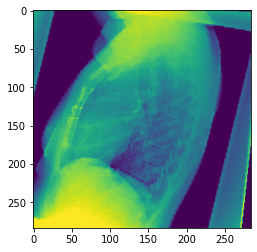

In [ ]:
all_files_df = pd.read_csv(HOME_DIR / 'combined_dataset.csv')
class CombinedDataset(Dataset):

  def __init__(self, df):
    super().__init__()
    self.df = df
    self.h5_names = df.h5_name.values
    self.index_in_file = df.index_in_file.values
    self.max_sizes = df['max'].values
    self.h5_files = HOME_DIR.glob('*/*.h5')
    self.imgs, self.img_names = self._load_h5_files()
    self.normalize = T.Normalize(116.59, 72.247)
    self.transform = T.Compose([
          # T.RandomPosterize(3, .2),
          T.RandomRotation(40, fill = 0),
          T.GaussianBlur(7),
          # T.RandomAutocontrast(0.5),
          T.RandomResizedCrop(284, (.30,1)),
          # T.RandomPerspective(.1),
          # T.RandomEqualize(0.2),
          T.ConvertImageDtype(torch.float),
          self.normalize
      ])
    self.debug = False
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img = self.get_image(idx)
    if self.max_sizes[idx] > 300:
      img = (img * 255) / 65536
      
    if self.debug == True:
      return self.normalize(torch.from_numpy(img))
      
    img = torch.tensor(img, dtype = torch.uint8)
    
    # Returns file normlaized onley
      
    img_1 = self.transform(img)
    img_2 = self.transform(img)
    return img_1, img_2

  def _load_h5_files(self):
    """
    Loads the generator of images and returns a dict
    """ 
    imgs = {}
    names = {}
    for file in self.h5_files:
      data = h5py.File(file)
      _imgs = data['img']
      _names = data['name']
      name = file.name
      imgs.update({name : _imgs})
      names.update({name : _names})
    return imgs, names

  def get_image(self, idx):
    file_name = self.h5_names[idx]
    index_in_file = self.index_in_file[idx]
    return self.imgs[file_name][index_in_file]
sim_nih_ds = CombinedDataset(all_files_df)
sim_nih_ds.debug = True
sim_nih_dl = DataLoader(sim_nih_ds, 4, shuffle = True, num_workers = 2)
img1  = next(iter(sim_nih_dl))
plt.imshow(img1[0,0,:])

#Training

### SIMCLR

You have to remember that the transformations that you apply will have a great effect on how things happend and how your model performs and how it learns a lot of the things

So please please, if after doing all this, things dont pan out as well, think of this step here and try to make a few changes whcihc can be more fruitful

In [ ]:
# plt.set_cmap('gray')
class SimCLRDataset(BaseDataset):
  def __init__(self, df, base_dir, normalize_val = (119.104, 68.831), transpose = False):
    super().__init__(df, base_dir)
    self.transpose = transpose
    self.transform = T.Compose([
        # T.RandomPosterize(3, .2),
        T.RandomRotation(40, fill = 0),
        T.GaussianBlur(7),
        # T.RandomAutocontrast(0.5),
        T.RandomResizedCrop(284, (.25,1)),
        # T.RandomPerspective(.1),
        # T.RandomEqualize(0.2),
        T.ConvertImageDtype(torch.float),
        T.Normalize(*normalize_val),
    ])
    
  def __getitem__(self, idx):
    file_name = str(self.file[idx])
    img = self.imgs[file_name][self.file_index[idx]]
    img = torch.tensor(img, dtype = torch.uint8)
    # if self.transpose:
      # img = img.transpose(1,2)
    # img = torch.tensor(img)
    img_1 = self.transform(img)
    img_2 = self.transform(img)
    # img_1 = self.three_channel(img_1)
    # img_2 = self.three_channel(img_2)
    return img_1, img_2

  def three_channel(self, img):
    return torch.cat((img,img,img),0)

# sim_nih_ds = SimCLRDataset(nih_df, HOME_DIR / 'nih')
# sim_nih_dl = DataLoader(sim_nih_ds, 4, shuffle = True, num_workers = 2)
# img1, img2 = next(iter(sim_nih_dl))
# fig, ax = plt.subplots(2,4, figsize = (30,20))
# for i in range(4):
#   ax[0,i].imshow(img1[i,0,:])
#   ax[1,i].imshow(img2[i,0,:])

In [ ]:
mod = models.regnet_x_8gf(weights = None)
mod

In [ ]:
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup

class SimCLR(pl.LightningModule):

  def __init__(
      self,
      temp,
      lr,
      weight_decay,
      steps_per_epoch,
      hidden_dim = 128,
      max_epochs= 100,
       ):
    
    super().__init__()
    self.save_hyperparameters()
    self.encoder = models.regnet_x_8gf(weights= None, num_classes = 4 * hidden_dim)
    self.encoder.stem = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True)
)
    self.classifier = nn.Sequential(
        nn.ReLU(True),
        nn.Linear(hidden_dim * 4, hidden_dim * 4),
        nn.ReLU(True),
        nn.Linear(hidden_dim * 4, hidden_dim)
    )
  def forward(self, x):
    x = self.encoder(x)
    return self.classifier(x)

  def training_step(self, batch, batch_idx):
    return self.info_nce_loss(batch, 'train')

  def validation_step(self, batch, batch_idx):
    return self.info_nce_loss(batch, 'val')
    
  def configure_optimizers(self):
    optimizer = optim.AdamW(
        self.parameters(),
        lr = self.hparams.lr,
        weight_decay = self.hparams.weight_decay
    )
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                        T_max = self.hparams.steps_per_epoch * self.hparams.max_epochs,
                                                        eta_min = 1e-5)
    with_warmup = create_lr_scheduler_with_warmup(
        lr_scheduler,
        warmup_start_value = 1e-5,
        warmup_duration = self.hparams.steps_per_epoch * 5,
        warmup_end_value = .8,
        )
    return [optimizer], [lr_scheduler]

  def get_latent(self, x):
    return self.encoder(x)

  def info_nce_loss(self, batch, mode = 'train'):
    xi, xj = batch
    batch_size = xi.shape[0]

    imgs= torch.cat([xi, xj], 0)
    feats = self(imgs)

    cos_sim = F.cosine_similarity(feats[:,None,:] ,feats[None,:,:], dim = -1)
    # Here I have gotten the similarity of each image with each other image
    mask = torch.eye(cos_sim.shape[0], dtype = torch.bool, device = self.device)
    cos_sim.masked_fill_(mask, -9e15)
    cos_sim /= self.hparams.temp
    pos_mask = mask.roll(cos_sim.shape[0] // 2, dims = 0)
    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, -1)
    nll = nll.mean()

    #  Logging all the above shit   
    self.log(mode+'_loss', nll)

    comb_sim = torch.cat([cos_sim[pos_mask][:,None], cos_sim.masked_fill(pos_mask, -9e15)], -1)
    sim_argsort = comb_sim.argsort(dim = -1, descending = True).argmin(dim = -1)
    # Logging ranking metrics
    self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
    self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
    self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

    return nll

In [ ]:
from pytorch_lightning import callbacks as cb
def train_simclr(model_name,batch_size, max_epochs=500, **kwargs):

    MODEL_NAME = model_name
    CHECKPOINT_PATH = HOME_DIR / 'models' / 'simclr' / 'full'
    NUM_WORKERS = 8

    logger = pl.loggers.WandbLogger(
        project = 'CXR',
      name = MODEL_NAME,
      group = 'simclr_full'    
    ) 

    trainer = pl.Trainer(default_root_dir=CHECKPOINT_PATH,
                          accelerator = 'auto',
                          max_epochs=max_epochs,
                          logger = logger,
                         callbacks=[
                             ModelCheckpoint(
                                 save_weights_only=True,
                                 filename = f'simclr-{MODEL_NAME}' + '-{epoch}-{val_loss:.2f}-{val_acc_top5:.2f}',
                                  mode='min',
                                   monitor='val_loss'
                                  ),
                             LearningRateMonitor('epoch'),
                             cb.StochasticWeightAveraging(swa_lrs=1e-2)
                             ],
                        #  num_sanity_val_steps=3,
                        #  overfit_batches=10,
                        #  log_every_n_steps = 5,
                        #  val_check_interval = .20,
                         precision = 16,
                         auto_scale_batch_size=True
                         )

    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    # if os.path.isfile(pretrained_filename):
    #     print(f'Found pretrained model at {pretrained_filename}, loading...')
    #     model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
# else:
    train_df, val_df = train_test_split(all_files_df, test_size = .15)
    train_ds = CombinedDataset(train_df)
    val_ds = CombinedDataset(val_df)                                    
    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True, drop_last = True, pin_memory = True, num_workers = NUM_WORKERS)
    val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False, drop_last = False, pin_memory = True, num_workers = NUM_WORKERS)
    
    pl.seed_everything(42, workers = True) # To be reproducable
    # model = SimCLR(max_epochs=max_epochs, steps_per_epoch = len(train_dl), **kwargs)
    model = simclr_model

    trainer.fit(
        model,
        train_dl,
        val_dl)
    
    model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [ ]:
simclr_model = train_simclr(
                            model_name = 'regnet_8_full',
                            batch_size=64,
                            hidden_dim=256,
                            lr=5e-4,
                            temp = 0.07,
                            weight_decay=1e-4,
                            max_epochs=100)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /content/drive/MyDrive/adv_cxr/models/simclr/full/regnet_8_full/2jmq032w/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:657: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
# modle = trainer.
# modle
torch.save(simclr_model.state_dict(), HOME_DIR / 'models' / 'simclr'/ 'full' / 'regnet_8_full_simclr.ckpt')

In [ ]:
wandb.finish()

### Rotation

In [ ]:
from torchvision import models
import torchmetrics as metrics

class RotationClassifier(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.save_hyperparameters()
    self.model = models.regnet_x_1_6gf(weights = None, num_classes = 4)
    self.loss_fn = self.get_loss_fn()
  
  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_idx):
    imgs, labels = self._preprocess(batch)
    logits = self(imgs)
    loss = F.cross_entropy(logits, labels)
    acc = self.accuracy(logits, labels)
    # if acc > 0.99 
      # print(logits.detach(), labels.detach())
    self.log('train_accuracy', acc, True)
    self.log("train_loss", loss)
    return loss
  
  def validation_step(self, batch, batch_idx):
    imgs, labels = self._preprocess(batch)
    logits = self(imgs)
    loss = F.cross_entropy(logits, labels)
    acc = self.accuracy(logits, labels)
    self.log('val_accuracy', acc, True)
    self.log("Val_loss", loss, True)

  def _preprocess(self, images):
    batch_size = images.shape[0]
    images_90 = torch.rot90(images, 1, (2,3))
    images_180 = torch.rot90(images, 2, (2,3))
    images_270 = torch.rot90(images, 3, (2,3))
    images_all = torch.cat((images, images_90, images_180, images_270), 0)
    targets = torch.arange(4, device = self.device).long().repeat(batch_size)
    targets = targets.view(batch_size, 4).transpose(0,1).contiguous().view(-1)
    random_indices = torch.randperm(batch_size * 4)
    images_all = images_all[random_indices, :]
    targets = targets[random_indices]
    return images_all, targets
    
  def get_loss_fn(self):
    return nn.BCEWithLogitsLoss()
  
  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(), lr = 1e-3)
  
  def accuracy(self, preds, targets):
    preds = preds.argmax(-1)
    correct = preds.eq(targets).float().sum()
    return (correct / targets.shape[0]).item()

### CLIP Model

## DINO Model

In [ ]:
class DINODataset(CombinedDataset):
  def __init__(self, df):
    super().__init__(df)
    self.coarse_transform = T.RandomResizedCrop((284,284), scale = (0.5,1.0))
    self.fine_transform = T.RandomResizedCrop((284,284), )
    self.common_transform = T.Compose([
        T.Resize((224, 224)),
        self.normalize
    ])

  def __getitem__(self, idx):
    img = self.get_image(idx)
    img = torch.from_numpy(img)
  
    if self.max_sizes[idx] > 300:
      img = (img * 255) / 65536

    img1 = self.coarse_transform(img)
    img2 = self.fine_transform(img)
    img1, img2 = self.common_transform(img1), self.common_transform(img2)
    # img1, img2 = img1.unsqueeze(0), img2.unsqueeze(0)
    # return torch.hstack((img1, img2))
    return img1, img2

class CollateFn:

  def reshape(self, batch):
    patches = batch.unfold(2, PATCH_SIZE, PATCH_SIZE).unfold(3, PATCH_SIZE, PATCH_SIZE)
    num_images = len(patches)
    patches = patches.reshape(
        num_images,
        RGB_CHANNELS,
        NUM_PATCHES,
        PATCH_SIZE,
        PATCH_SIZE
    )

    patches.transpose_(1,2)
    return patches


  def __call__(self, x):
    print(len(x))
    img1, img2 = zip(*x)
    return self,reshape(img1), self.reshape(img2)
    
dino_ds = DINODataset(all_files_df)
dino_dl = DataLoader(dino_ds, 4, shuffle = True,  )
img1, img2  = next(iter(dino_dl))
batch = next(iter(dino_dl))
len(batch[0][0])
# fig, ax = plt.subplots(2,4, figsize = (30,20))
# for i in range(4):
  # ax[0,i].imshow(img1[i,0,:])
  # ax[1,i].imshow(img2[i,0,:])

1

torch.Size([4, 768, 14, 14])

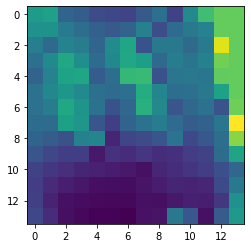

In [ ]:
from torch.nn.modules.conv import Conv2d
patcher = nn.Conv2d(1,768,16,16)
patch_img = patcher(img1)
plt.imshow(patch_img[0,0,:].detach())
patch_img.shape

In [ ]:
class Model(nn.Module):
  def __init__(self, d_model, n_head, n_layers):
    super().__init__()
    encoder_layer = nn.TransformerEncoderLayer(d_model = d_model, nhead = h_head)
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers = n_layers)

    # Pos encoding
    w_pos = torch.randn(NUM_PATCHES, d_model) / d_model ** 0.5
    cls_token = torch.randn(1, d_model) / d_model ** 0.5
    self.register_parameter('pos_embed', nn.Parameter(w_pos))
    self.register_parameter('cls_token', nn.Parameter(cls_token))

    # pixel Projection
    self.linear = nn.Linear(2 * d_model, d_model)
    self.norm1 = nn.LayerNorm(2 * d_model, elementwise_affine=False)
    self.norm2 = nn.LayerNorm(d_model)

  def forward(self, x):
    batch_size = len(x) 
    position = torch.stack([x] * batch_size)
    x = torch.cat([x, position], dim = -1)


In [ ]:
class HLoss:
  def __init__(self, temp_t, temp_s):
    self.temp_t = temp_t
    self.temp_s = temp_s

  def __call__(self, t, s, center):
    t = F.softmax((t.detach() - center) / self.temp_t, dim = 1)
    log_s = F.log_softmax(s / self.temp_s, dim = 1)
    return -(t * log_s).sum().mean()

In [ ]:
class LightningModel(pl.LightningModule):
  def __init__(
      self,
      teacher : nn.Module,
      lr,
      loss_fn: Callable,
      valid_files: List[str],
      dim: int,
      center_momentum: flaot,
      param_momentum: fLoat
  ):
    super().__init__()
    self.teacher = teacher
    self.student = copy.deepcopy(teacher)
    self.lr = lr
    self.loss_fn = loss_fn
    self.c_mon = center_momentum
    self.p_mon = param_momentum
    self.register_buffer('center', torch.zeros,((1, dim)).float())
    self.valid_files = valid_files
    for p in teacher.parameters():
      p.requires_grad = False

    def loss_calculation(self, batch: Tuple[torch.FloatTernsor, torch.FloatTernsor]):
      x1, x2 = batch

      s1, s2 = self.student(x1),self.student(x2)
      t1, t2 = self.teacher(x1),self.teacher(x2)

      loss = self.loss_fn(t1, s2, self.center) + self.loss_fn(t2, s1, self.center)

      empirical_center = F.normalize(
          torch.cat
      )

I input A batch of lets say B images,

each image has C x H x W, so in total we have 

B x C x H x W.

Now what we do is split it into different patches of lets say patch dims of P and we get N patches out of each image

so after changing the dims we get

B x N x C x P x P.

dino take 2

In [ ]:
from torchvision.transforms.functional import InterpolationMode
class DatAugmentation:
  def __init__(
      self,
      global_crop = (0.4,1.),
      local_crops_scale = (0.05,0.4),
      n_local_crops = 8,
      size = 224
  ):
    self.n_local_crops = n_local_crops
    
    # Some augmentations

    rotation = T.RandomRotation(45)
    rand_gaus_blur = lambda x : T.RandomApply(
        [
            T.GaussianBlur(5)
        ], p = x
    )
    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize(119.104, 68.831)
    ])
    random_resize_crop = lambda x : T.RandomResizedCrop(
        size,
        scale = x,
        interpolation=InterpolationMode.BICUBIC
    )
    self.global1 = T.Compose([
        random_resize_crop(global_crop),
        rotation,
        rand_gaus_blur(1.0),
        normalize
    ])

    self.global2 = T.Compose([
        random_resize_crop(global_crop),
        rotation,
        rand_gaus_blur(0.1),
        T.RandomSolarize(170, p = 0.2),
        normalize
    ])
    
    self.local = T.Compose([
        random_resize_crop(local_crops_scale),
        rotation,
        rand_gaus_blur(0.5),
        normalize
    ])

    def __call__(self, img):
      '''
      i have all the different images here and i will feed in the first 2 for the teacher network
      '''
      all_crops = []
      all_crops.append(self.global1(img))
      all_crops.append(self.global2(img))
      all_crops.extend([self.local(img) for _ in range(self.n_local_crops)])
      return all_crops
class Head(nn.Module):
  def __init__(
      self,
      in_dim,
      out_dim,
      hidden_dim = 512,
      bottleneck_dim = 256,
      n_layers = 3,
      norm_last_layer = False
  ):
    super().__init__()

    if n_layers == 1:
      self.mlp = nn.Linear(in_dim, bottleneck_dim)
    else:
      layers = [nn.Linear(in_dim, hidden_dim)]
      layers.append(nn.GELU())
      for _ in range(n_layers - 2):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.GELU())
      layers.append(nn.Linear(hidden_dim, bottleneck_dim))
      self.mlp = nn.Sequential(*layers)

    self.apply(self._init_weights)

    self.last_layer = nn.utils.weight_norm(
        nn.Linear(bottleneck_dim, out_dim, bias = False)
    )
# Settind the norm here equal to one
    self.last_layer.weight_g.data.fill_(1)

    if norm_last_layer:
      self.last_layer.weight_g.requires_grad = False

  def _init_weights(self, m):
    if isinstance(m, nn.Linear):
      nn.init.normal_(m.weight, std = 0.02)   
      if m.bias is not None:
        nn.init.constant(m.bias, 0)

  def forward(self, x):
    '''
    x is of shapE n_samples, in_diM

    '''
    x = self.mlp(x)
    x = F.normalize(x, dim = -1, p = 2)
    x = self.last_layer(x)
    return x

class MultiCropWrapper(nn.Module):
  def __init__(self, backbone, new_head):
    super().__init__()
    backbone.head = nn.Identity()
    self.backbone = backbone
    self.new_head = new_head

  def forward(self, x):
    n_crops = len(x)
    concatenated = torch.cat(x, dim = 0)# (n_Samples * n_crops, 1, patch_size, patch_size)
    cls_embed = self.backbone(concatenated)
    logits = self.new_head(cls_embed)
    chunks = logits.chunk(n_crops)
    return chunks

class Loss(nn.Module):
  def __init__(
      self,
      out_dim,
      t_temp = 0.04,
      s_temp = 0.1,
      center_momentum = 0.9
  ):
    super().__init__()
    self.s_temp = s_temp
    self.t_temp = t_temp
    self.center_momentum = center_momentum
    self.register_buffer('center', torch.zeros(1, out_dim))

  def forward(self, s_output, t_output):
    student_temp = [s / self.s_temp for s in s_output]
    teacher_temp = [(t - self.center) / self.t_temp for t in t_output]

    student_sm = [F.log_softmax(s, dim = -1) for s in student_temp]
    # here the detach is our way of tellig that we are not going to update the graph of our teacher model through backprop
    teacher_sm = [F.softmax(t, dim = -1).detach() for t in teacher_temp]

    total_loss = 0
    n_loss_terms = 0

    for t_ix, t in enumerate(teacher_sm):
      for s_ix, s in enumerate(student_sm):
        if t_ix == s_ix: continue

        loss = torch.sum(-t * s, dim = -1)
        total_loss += loss.mean()
        n_loss_terms += 1

    total_loss /= n_loss_terms
    self.update_center(t_output)
    return total_loss

  @torch.no_grad()
  def update_center(self, t_output):
    # Using keepdims so thAt it remains broadcastable
    batch_center = torch.cat(t_output).mean(dim = 0, keepdim = True) # (1, out_dim)
    self.center = self.center * self.center_momentum + batch_center * ( 1 - self.center_momentum)

def clip_gradients(model, clip=2.0):
  """Rescale norm of computed gradients.
  Parameters
  ----------
  model : nn.Module
      Module.
  clip : float
      Maximum norm.
  """
  for p in model.parameters():
      if p.grad is not None:
          param_norm = p.grad.data.norm(2)
          clip_coef = clip / (param_norm + 1e-6)
          if clip_coef < 1:
              p.grad.data.mul_(clip_coef)

In [ ]:
from timm.models.layers import norm
from timm.models.vision_transformer import VisionTransformer
student = VisionTransformer(
    img_size = 224,
    patch_size = 16,
    in_chans = 1,
    embed_dim = 768
)

teacher = copy.deepcopy(student)

student = MultiCropWrapper(
    student,
    Head(
        in_dim = 768,
         out_dim = 256,
         norm_last_layer = False
    )
)

teacher = MultiCropWrapper(
    teacher,
    Head(
        in_dim = 768,
         out_dim = 256,
    )
)
teacher.load_state_dict(student.state_dict())
teacher.requires_grad_(False)

class DinoModel(pl.LightningModule):
  def __init__(self):
    self.student = student
    self.teacher = teacher
    self.loss_fn = Loss(OUT_DIM)
    ,
  def configure_optimizers(self):
      optimizer = optim.AdamW(
          self.student.parameters(),
          lr = self.hparams.lr,
          weight_decay=1e-4
      )
      return optimizer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
